In [1]:
# Experiment 1: Visual Place Recognition with Positive Transformation
# Dataset: GardensPointWalking (day_left vs night_right)
# Feature Descriptors: DELF-HDC
# Descriptor Dimensions: 4096
# Transformation: Positive shift with normalization
# Purpose: Evaluate impact of positive transformation on VPR performance

In [2]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'lib')))

from randn2 import randn2 
import math
from tqdm import tqdm

In [4]:
import peer_functions as peer
# import lava_dot_prod as snn

In [5]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

In [6]:
D1    = loadmat("../datasets/descriptors/GardensPointWalking/day_left/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']
D2    = loadmat("../datasets/descriptors/GardensPointWalking/night_right/delf_hdc_4096_ortho_sigma_nx5ny7.mat")['Y']

g_truth = loadmat("../datasets/ground_truth/GardensPointWalking/day_left--night_right/gt.mat")

In [7]:
# D1 = D1[:,:500]
# D2 = D2[:,:500]

In [8]:
normalizer = Normalizer()

mu1 = np.mean(D1,axis=0)

D1_centered = np.subtract(D1,mu1)  # database
D2_centered = np.subtract(D2,mu1)

D1_norm = normalizer.fit_transform(D1_centered)
D2_norm = normalizer.fit_transform(D2_centered)

In [9]:
constant = 1/math.sqrt(2)
print(constant)

0.7071067811865475


In [10]:
D1_norm_pos = D1_norm + constant
D2_norm_pos = D2_norm + constant

normalizer = Normalizer()

D1_norm_pos = normalizer.fit_transform(D1_norm_pos)
D2_norm_pos = normalizer.fit_transform(D2_norm_pos)

In [11]:
DD_pos = cdist(D1_norm_pos, D2_norm_pos, 'cosine')
DD     = cdist(D1_norm, D2_norm, 'cosine')

In [12]:
# select candidates k indices
ids_pos = peer.directCandSel(DD_pos)

# calculate recall values
recalls_pos = peer.getRecallAtKVector(ids_pos, g_truth["GT"])

[R, P] = peer.createPR(-DD_pos, g_truth['GT']["GThard"][0][0], g_truth['GT']["GTsoft"][0][0])
AUC_Peer_Pos = np.trapz(P,R)
print(AUC_Peer_Pos)

0.4660135714632877


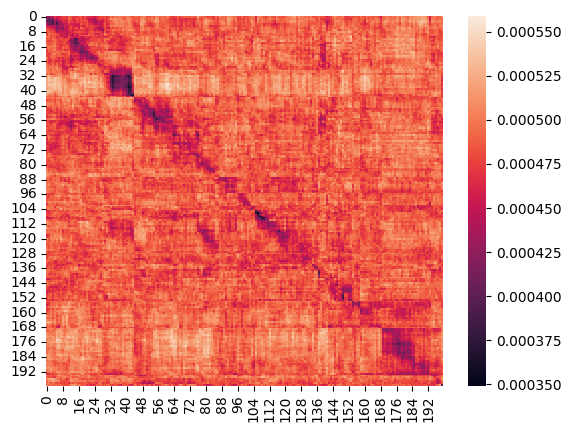

In [13]:
import seaborn as sns

ax = sns.heatmap(DD_pos)
plt.show()

In [14]:
# select candidates k indices
ids = peer.directCandSel(DD)

# calculate recall values
recalls = peer.getRecallAtKVector(ids, g_truth["GT"])

[R, P] = peer.createPR(-DD, g_truth['GT']["GThard"][0][0], g_truth['GT']["GTsoft"][0][0])
AUC_Peer = np.trapz(P,R)
print(AUC_Peer)

0.4702147082864312


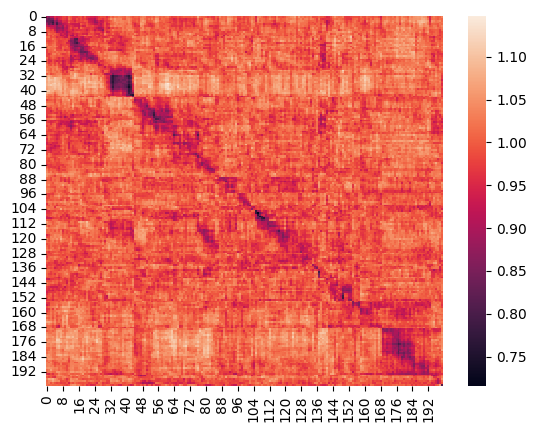

In [15]:
ax = sns.heatmap(DD)
plt.show()

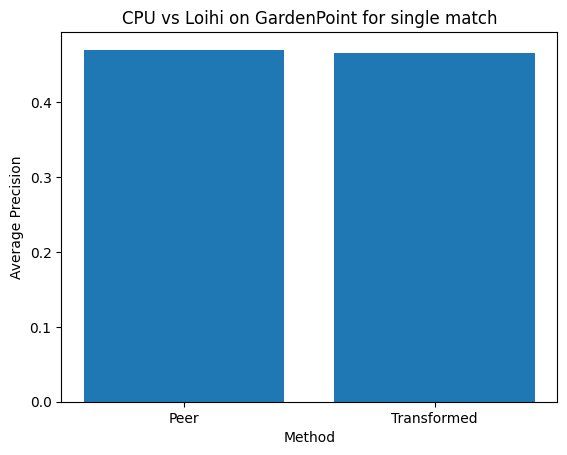

In [16]:
config = ["Peer", "Transformed"]
values = [ AUC_Peer, AUC_Peer_Pos ]
  
plt.bar(config, values)
 
plt.xlabel("Method")
plt.ylabel("Average Precision")
plt.title("CPU vs Loihi on GardenPoint for single match")
plt.show()

In [60]:
variable_constant = [ i for i in range(0,100, 5)]
auc_vs_constant = []

In [61]:
# %%script echo skipping
for constant in variable_constant:
    D1_norm_pos = D1_norm + constant
    D2_norm_pos = D2_norm + constant
    
    normalizer = Normalizer()
    
    D1_norm_pos = normalizer.fit_transform(D1_norm_pos)
    D2_norm_pos = normalizer.fit_transform(D2_norm_pos)

    DD_pos = cdist(D1_norm_pos, D2_norm_pos, 'cosine')

    # select candidates k indices
    ids_pos = peer.directCandSel(DD_pos)
    
    # calculate recall values
    recalls_pos = peer.getRecallAtKVector(ids_pos, g_truth["GT"])
    
    [R, P] = peer.createPR(-DD_pos, g_truth['GT']["GThard"][0][0], g_truth['GT']["GTsoft"][0][0])
    AUC_Peer_Pos = np.trapz(P,R)
    auc_vs_constant.append(AUC_Peer_Pos)

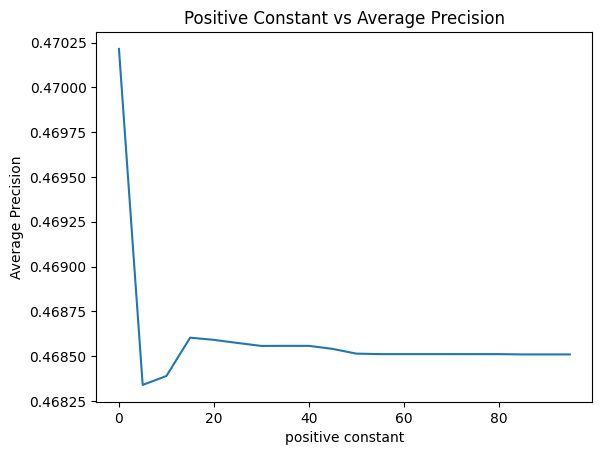

In [62]:
# %%script echo skipping
plt.plot(variable_constant, auc_vs_constant)

plt.xlabel("positive constant")
plt.ylabel("Average Precision")
plt.title("Positive Constant vs Average Precision")
plt.show()

In [63]:
variable_constant = [ i/10 for i in range(0,200,2)]
auc_vs_constant = []

In [64]:
# %%script echo skipping
for constant in variable_constant:
    D1_norm_pos = D1_norm + constant
    D2_norm_pos = D2_norm + constant
    
    normalizer = Normalizer()
    
    D1_norm_pos = normalizer.fit_transform(D1_norm_pos)
    D2_norm_pos = normalizer.fit_transform(D2_norm_pos)

    DD_pos = cdist(D1_norm_pos, D2_norm_pos, 'cosine')

    # select candidates k indices
    ids_pos = peer.directCandSel(DD_pos)
    
    # calculate recall values
    recalls_pos = peer.getRecallAtKVector(ids_pos, g_truth["GT"])
    
    [R, P] = peer.createPR(-DD_pos, g_truth['GT']["GThard"][0][0], g_truth['GT']["GTsoft"][0][0])
    AUC_Peer_Pos = np.trapz(P,R)
    auc_vs_constant.append(AUC_Peer_Pos)

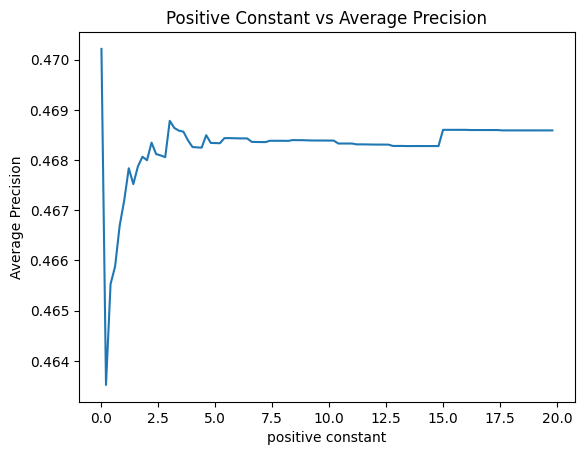

In [65]:
# %%script echo skipping
plt.plot(variable_constant, auc_vs_constant)

plt.xlabel("positive constant")
plt.ylabel("Average Precision")
plt.title("Positive Constant vs Average Precision")
plt.show()

In [66]:
variable_dim = [ i for i in range(10,10000, 200)]
auc_vs_dim = []

constant = 2.5

In [67]:
D1_norm[:,:10].shape

(200, 10)

In [68]:
# %%script echo skipping
for i, dim in enumerate(tqdm(variable_dim)):
    D1_norm_pos = D1_norm[:,:dim] + constant
    D2_norm_pos = D2_norm[:,:dim] + constant
    
    normalizer = Normalizer()
    
    D1_norm_pos = normalizer.fit_transform(D1_norm_pos)
    D2_norm_pos = normalizer.fit_transform(D2_norm_pos)

    DD_pos = cdist(D1_norm_pos, D2_norm_pos, 'cosine')

    # select candidates k indices
    ids_pos = peer.directCandSel(DD_pos)
    
    # calculate recall values
    recalls_pos = peer.getRecallAtKVector(ids_pos, g_truth["GT"])
    
    [R, P] = peer.createPR(-DD_pos, g_truth['GT']["GThard"][0][0], g_truth['GT']["GTsoft"][0][0])
    AUC_Peer_Pos = np.trapz(P,R)
    auc_vs_dim.append(AUC_Peer_Pos)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:14<00:00,  3.38it/s]


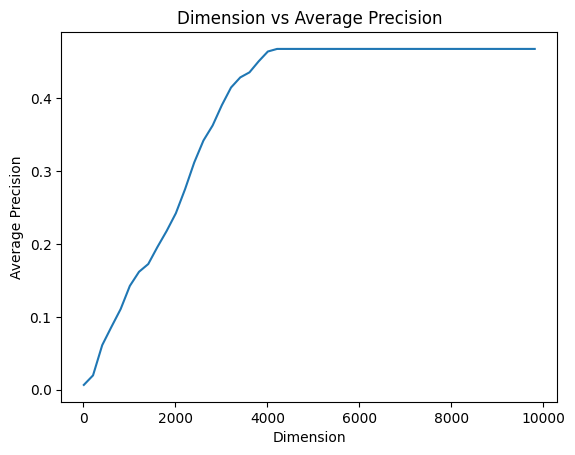

In [69]:
# %%script echo skipping
plt.plot(variable_dim, auc_vs_dim)

plt.xlabel("Dimension")
plt.ylabel("Average Precision")
plt.title("Dimension vs Average Precision")
plt.show()

In [70]:
print(D2_norm_pos.shape)
print(constant)

(200, 4096)
2.5


## Loihi Dot Prod

In [26]:
from scipy.io import loadmat, savemat
from scipy.linalg import orth
import numpy as np
import faiss
from scipy.spatial.distance import cdist
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
import gc
from randn2 import randn2 
import math
from tqdm import tqdm
import peer_functions as peer
import lava_dot_prod as snn

In [27]:
constant = 1/math.sqrt(2)
print(constant)

0.7071067811865475


In [28]:
D1_norm_pos = D1_norm + constant
D2_norm_pos = D2_norm + constant

normalizer = Normalizer()

D1_norm_pos = normalizer.fit_transform(D1_norm_pos)
D2_norm_pos = normalizer.fit_transform(D2_norm_pos)

In [29]:
# normalizer = Normalizer()

# mu1 = np.mean(D1,axis=0)

# D1_centered = np.subtract(D1,mu1)
# D2_centered = np.subtract(D2,mu1)

# D1_norm = normalizer.fit_transform(D1_centered)
# D2_norm = normalizer.fit_transform(D2_centered)

In [30]:
# constant = abs(np.min(np.minimum(D1_norm, D2_norm)))
# print(constant)

In [31]:
# D1_norm_pos = D1_norm + constant
# D2_norm_pos = D2_norm + constant

# normalizer = Normalizer()

# D1_norm_pos = normalizer.fit_transform(D1_norm_pos)
# D2_norm_pos = normalizer.fit_transform(D2_norm_pos)

In [32]:
np.min(np.minimum(D1_norm_pos, D2_norm_pos))

0.013511314933757573

In [33]:
np.mean(D1_norm_pos[0])

0.015621186005194224

In [34]:
DD = snn.cdistLoihiSingleProgramPositive(D1_norm_pos, D2_norm_pos)

[[17.64574186  6.65332047  9.96248182 ... 11.51374263  9.41505131 12.33497233]
 [14.32778129  5.79299371 10.49875456 ... 12.13492206 14.36467693 16.00070459]
 [14.31656998 12.05833174 10.65895406 ... 12.41659828 14.69125839 15.91358251]
 ...
 [19.05278299 16.07085122 11.21466754 ... 13.28258247 15.28946556 14.98171616]
 [12.70915709 13.29235727  7.0386698  ... 16.42602388 16.28073336 13.58768225]
 [11.12379492  3.75965926 15.78985639 ... 13.610346   11.96051343 12.38878765]]
[49.434157703342976, 4.880741609512256, 25.303413781191807, 23.170035921263434, 2.968701223952962, 11.885000915908904, 19.332713840161887, 23.755633626831354, 9.453351428125643, 0.06234938763861919]
[0.43415770334297576, -44.119258390487744, -23.696586218808193, -25.829964078736566, -46.03129877604704, -37.114999084091096, -29.667286159838113, -25.244366373168646, -39.54664857187436, -48.93765061236138]
Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neuro

/homes/viduras/lava/lava-0.4.1/lib/python3.8/site-packages/nxcore/arch/base/nxboard.py:71: UserWarning: Partition None overridden by environment variable PARTITION=oheogulch_2h
  warnings.warn("Partition {} overridden by environment variable PARTITION={}".format(partition,os.environ["PARTITION"]))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [24:12<00:00,  7.26s/it]


In [35]:
print(DD.shape)
DD[0]

(200, 200)


array([0.99974434, 0.99973453, 0.99975608, 0.99975418, 0.99977436, 0.99976788, 0.99977235, 0.99977891,
       0.99978773, 0.9997846 , 0.99978011, 0.99980169, 0.99978239, 0.9997707 , 0.99977925, 0.99977686,
       0.99978672, 0.99979317, 0.99977944, 0.9997917 , 0.9997774 , 0.99977495, 0.99977239, 0.99976665,
       0.99976633, 0.99976438, 0.99978024, 0.9997894 , 0.9997872 , 0.99979051, 0.99977776, 0.99978503,
       0.99980713, 0.99978962, 0.99980981, 0.99980146, 0.9998002 , 0.99980481, 0.99979611, 0.99979559,
       0.99980872, 0.99980728, 0.99979599, 0.99978911, 0.99979478, 0.99979801, 0.99979099, 0.99980252,
       0.99980652, 0.99980951, 0.99979209, 0.99979366, 0.99979365, 0.99979871, 0.99979137, 0.99981175,
       0.99980557, 0.99979758, 0.99980129, 0.99979853, 0.99980266, 0.99980862, 0.99979531, 0.99978657,
       0.99978585, 0.99978091, 0.9997929 , 0.99978386, 0.99979257, 0.99979839, 0.99979722, 0.99979366,
       0.99979869, 0.99979459, 0.99979486, 0.99979514, 0.99982572, 0.9998

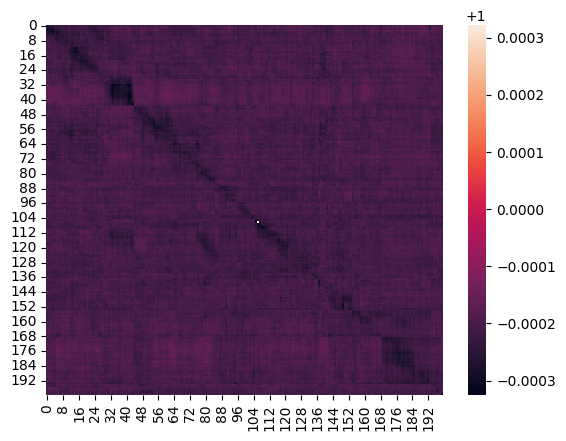

In [36]:
ax = sns.heatmap(DD)
plt.show()

In [37]:
# select candidates k indices

ids = peer.directCandSel(DD)

# calculate recall values
recalls = peer.getRecallAtKVector(ids, g_truth["GT"])

[R, P] = peer.createPR(-DD, g_truth['GT']["GThard"][0][0], g_truth['GT']["GTsoft"][0][0])
AUC_Peer = np.trapz(P,R)
print(AUC_Peer)

0.43656556467008767


In [38]:
0.43656556467008767

0.43656556467008767

In [39]:
def extend_array_rows(input_array, required_rows):
    
    if required_rows <= input_array.shape[0]:
        return input_array[:required_rows]
    else:
        repeats = required_rows // input_array.shape[0] + 1
        extended_array = np.tile(input_array, (repeats, 1))
        return extended_array[:required_rows]

In [43]:
D1_norm_pos_ext = extend_array_rows(D1_norm_pos, 400)
D2_norm_pos_ext = extend_array_rows(D2_norm_pos, 400)

In [44]:
DD = snn.cdistLoihiSingleProgramPositive(D1_norm_pos_ext, D2_norm_pos_ext)

[[17.64574186  6.65332047  9.96248182 ... 11.51374263  9.41505131 12.33497233]
 [14.32778129  5.79299371 10.49875456 ... 12.13492206 14.36467693 16.00070459]
 [14.31656998 12.05833174 10.65895406 ... 12.41659828 14.69125839 15.91358251]
 ...
 [19.05278299 16.07085122 11.21466754 ... 13.28258247 15.28946556 14.98171616]
 [12.70915709 13.29235727  7.0386698  ... 16.42602388 16.28073336 13.58768225]
 [11.12379492  3.75965926 15.78985639 ... 13.610346   11.96051343 12.38878765]]
[49.434157703342976, 4.880741609512256, 25.303413781191807, 23.170035921263434, 2.968701223952962, 11.885000915908904, 19.332713840161887, 23.755633626831354, 9.453351428125643, 0.06234938763861919]
[0.43415770334297576, -44.119258390487744, -23.696586218808193, -25.829964078736566, -46.03129877604704, -37.114999084091096, -29.667286159838113, -25.244366373168646, -39.54664857187436, -48.93765061236138]
Per core distribution:
----------------------------------------------------------------
| AxonIn |NeuronGr| Neuro

/homes/viduras/lava/lava-0.4.1/lib/python3.8/site-packages/nxcore/arch/base/nxboard.py:71: UserWarning: Partition None overridden by environment variable PARTITION=oheogulch_2h
  warnings.warn("Partition {} overridden by environment variable PARTITION={}".format(partition,os.environ["PARTITION"]))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [1:12:42<00:00, 10.91s/it]


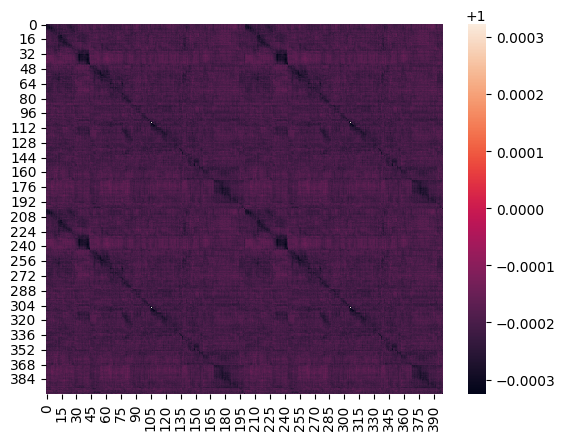

In [45]:
ax = sns.heatmap(DD)
plt.show()